<a href="https://colab.research.google.com/github/wakepon21/Masa/blob/master/signate1_5_day_and_month.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

9回目の提出さ

ここまでのtry
*   Light GBM、特徴量12個くらい。MinMaxScalerで正規化したけど、不必要かも
*   基準を0.1以上をOKとしたらクリアになった。？？？？怪しいな
*   crossvalidationがちゃんと働いてないな。
*　 cataegorical featuresという形でもうできることがわかったぞ


---


今後の課題
*   optunaを入れて調整しよう
*   過学習の判断をできるようにしよう
*   Minmaxとかの正規化ってcategoricaldataにもやっていいの？
*   
*   


In [18]:
#importまとめ。pandas-profilingは少々導入が面倒
!pip install git+https://github.com/pandas-profiling/pandas-profiling.git
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pandas_profiling
import seaborn as sns
from pandas_profiling.utils.cache import cache_file
%matplotlib inline

warnings.filterwarnings('ignore')

  Cloning https://github.com/pandas-profiling/pandas-profiling.git to /tmp/pip-req-build-sm0x27fe
  Running command git clone -q https://github.com/pandas-profiling/pandas-profiling.git /tmp/pip-req-build-sm0x27fe
  Created wheel for pandas-profiling: filename=pandas_profiling-2.9.0rc1-py2.py3-none-any.whl size=258106 sha256=15c5d436092bdb9ef67ed26e0346390d3db5e9369ff20b0c70677c27f0b50467
  Stored in directory: /tmp/pip-ephem-wheel-cache-cx70d7he/wheels/cd/13/75/8fcecd52c706914e90d916ede57f8c74de60e4c9ebc6c2f3b7
Successfully built pandas-profiling


In [19]:
#train,test,submit_sampleのみっつがそろっているか確認
!ls

sample_data		       submit_sample.csv  train.csv
submission_lightgbm_kfold.csv  test.csv


In [20]:
#そろっていなかったら選択
from google.colab import files
train_up = files.upload()

Saving submit_sample.csv to submit_sample (1).csv
Saving test.csv to test (1).csv
Saving train.csv to train (1).csv


In [128]:
!ls

 sample_data			 submit_sample.csv  'train (1).csv'
 submission_lightgbm_kfold.csv	'test (1).csv'	     train.csv
'submit_sample (1).csv'		 test.csv


In [227]:
#上手く列指定ができなかったので、先頭にheaderをつける
sub = pd.read_csv("submit_sample.csv",names=("A","B"))
#test,train,その足し合わせdataの三種を作る
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
train=train.sort_values(by='y')
y1train=sum(train["y"])
for i in range(12):
    train.index = range(len(train))
    train = pd.concat([train,train[len(train)-y1train:len(train)]], sort=False)
train = train.sample(frac=1)
train.index = range(len(train))

In [228]:
sum(train["y"])

27456

In [229]:
len(train)

52444

In [230]:
train["y"]

0        0
1        1
2        0
3        0
4        1
        ..
52439    1
52440    0
52441    1
52442    0
52443    1
Name: y, Length: 52444, dtype: int64

In [231]:
train

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,11201,37,admin.,single,secondary,no,42110,yes,no,unknown,16,may,121,1,518,0,unknown,0
1,14144,35,retired,married,secondary,no,44658,no,no,cellular,30,apr,14,1,534,2,failure,1
2,16314,35,technician,married,unknown,no,81640,yes,no,cellular,27,may,121,1,385,1,failure,0
3,24504,32,self-employed,married,tertiary,no,72774,yes,yes,cellular,7,jul,271,1,65,0,unknown,0
4,4951,30,housemaid,married,primary,no,96655,no,no,cellular,13,jul,158,1,575,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52439,713,36,housemaid,married,primary,no,35152,no,no,cellular,18,aug,158,2,26,0,unknown,1
52440,12794,29,management,single,tertiary,no,94562,yes,no,cellular,28,jul,518,4,387,1,failure,0
52441,18147,49,management,married,tertiary,no,22037,no,no,cellular,30,apr,605,2,368,1,success,1
52442,24525,43,self-employed,married,tertiary,no,43185,no,no,cellular,28,aug,158,2,268,0,unknown,0


In [232]:

data = pd.concat([train,test], sort=False)

#特徴量をエンジニアリング
data["job"].replace(['blue-collar','management','technician','admin.','services','unknown','self-employed','entrepreneur','student','retired','unemployed','housemaid'],[0,1,2,3,4,5,6,7,8,9,10,11],inplace=True)
data["loan"].replace(['yes','no'],[1,0],inplace=True)
data["marital"].replace(['married','single','divorced'],[2,1,0],inplace=True)
data['education'].replace(['secondary','tertiary','primary','unknown'],[3,2,1,0],inplace=True)
data["housing"].replace(['yes','no'],[1,0],inplace=True)
data["contact"].replace(['cellular','telephone','unknown'],[2,1,0],inplace=True)
data["poutcome"].replace(['success','failure','unknown','other'],[3,2,1,0],inplace=True)
data["job"] = data["job"].astype(np.int64)
data["month"].replace(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','des'],[3,4,5,6,7,8,9,10,11,0,1,2],inplace=True)

#全体のうち、残したいモノだけ選ぶ
all_columns = ['id','age','job','marital','education','default','balance','housing','loan','contact','day','month','duration','campaign','pdays','previous','poutcome']
remain_columns = ['age','job','marital','education','balance','housing','loan','contact','day','month','duration','campaign','pdays','previous','poutcome']
delete_columns = list(set(all_columns)-set(remain_columns))
data.drop(delete_columns, axis=1, inplace=True)

#trainとtestを再度切り分け
train = data[:len(train)]
test = data[len(train):]


**------------------cross validation--------------------**


**------light GBM-------**

In [233]:
#train,testを、さらに説明変数Xと、予測変数yに切り分け。y_testは与えられていないのでなし。三種類がでる
y_train = train['y']
X_train = train.drop('y', axis = 1)
X_test = test.drop('y', axis = 1)

# MinmaxScalarを使って正規化。
from sklearn.preprocessing import MinMaxScaler
mmsc = MinMaxScaler()
# 訓練用のデータを正規化する。fit_transformはfit＆transformの略で、情報取得＆正規化の意味
X_train_norm = mmsc.fit_transform(X_train)
# 訓練用データを基準にテストデータも正規化
X_test_norm = mmsc.transform(X_test)
X_train=X_train_norm
X_test=X_test_norm
#正規化するとarrayになっていたので、DataFrameに戻す
X_train=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)
#Dataflameにしたらheaderが抜けていたので付け直す
X_train.columns=remain_columns
X_test.columns=remain_columns
#この辺のheader周りの操作は無駄なのでできたら修正したい

In [234]:
#欲しいデータが見えているか確認
data

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,37,3,1,3,42110,1,0,0,16,7,121,1,518,0,1,0.0
1,35,9,2,3,44658,0,0,2,30,6,14,1,534,2,2,1.0
2,35,2,2,0,81640,1,0,2,27,7,121,1,385,1,2,0.0
3,32,6,2,2,72774,1,1,2,7,9,271,1,65,0,1,0.0
4,30,11,2,1,96655,0,0,2,13,9,158,1,575,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18045,49,6,2,2,98357,1,0,2,6,9,101,2,417,0,2,NaN
18046,34,0,2,3,29621,1,0,2,12,7,345,1,815,0,1,NaN
18047,34,3,1,3,94260,1,0,0,16,7,121,2,370,0,1,NaN
18048,31,2,1,3,65483,1,0,0,15,7,345,2,41,0,1,NaN


In [235]:
remain_columns

['age',
 'job',
 'marital',
 'education',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome']

In [236]:
X_train

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,0.220588,0.272727,0.5,1.000000,0.449279,1.0,0.0,0.0,0.500000,0.636364,0.039337,0.00,0.595867,0.000000,0.333333
1,0.191176,0.818182,1.0,1.000000,0.472662,0.0,0.0,1.0,0.966667,0.545455,0.004551,0.00,0.614237,0.666667,0.666667
2,0.191176,0.181818,1.0,0.000000,0.812046,1.0,0.0,1.0,0.866667,0.636364,0.039337,0.00,0.443169,0.333333,0.666667
3,0.147059,0.545455,1.0,0.666667,0.730682,1.0,1.0,1.0,0.200000,0.818182,0.088101,0.00,0.075775,0.000000,0.333333
4,0.117647,1.000000,1.0,0.333333,0.949838,0.0,0.0,1.0,0.400000,0.818182,0.051365,0.00,0.661309,0.000000,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52439,0.205882,1.000000,1.0,0.333333,0.385425,0.0,0.0,1.0,0.566667,0.909091,0.051365,0.25,0.030999,0.000000,0.333333
52440,0.102941,0.090909,0.5,0.666667,0.930631,1.0,0.0,1.0,0.900000,0.818182,0.168401,0.75,0.445465,0.333333,0.666667
52441,0.397059,0.090909,1.0,0.666667,0.265069,0.0,0.0,1.0,0.966667,0.545455,0.196684,0.25,0.423651,0.333333,1.000000
52442,0.308824,0.545455,1.0,0.666667,0.459144,0.0,0.0,1.0,0.900000,0.909091,0.051365,0.25,0.308840,0.000000,0.333333


In [237]:
#LightGBMに入れる。
from sklearn.model_selection import KFold
import lightgbm as lgb

y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=3, shuffle=True, random_state=0)

#categorical dataの入れ忘れに注意
categorical_features = ['job','marital','education','housing','loan','contact','duration','poutcome']

params = {
    'objective': 'binary',
    'max_bin': 400,
    'learning_rate': 0.1,
    'num_leaves': 40
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr, y_tr,
                                             categorical_feature=categorical_features)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train,
                                            categorical_feature=categorical_features)
    model = lgb.train(params, lgb_train,
                                   valid_sets=[lgb_train, lgb_eval],
                                   verbose_eval=10,
                                   num_boost_round=1000,
                                   early_stopping_rounds=10)
    
    oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.53765	valid_1's binary_logloss: 0.541373
[20]	training's binary_logloss: 0.486527	valid_1's binary_logloss: 0.494562
[30]	training's binary_logloss: 0.453672	valid_1's binary_logloss: 0.466677
[40]	training's binary_logloss: 0.431349	valid_1's binary_logloss: 0.447726
[50]	training's binary_logloss: 0.413156	valid_1's binary_logloss: 0.432686
[60]	training's binary_logloss: 0.395378	valid_1's binary_logloss: 0.417265
[70]	training's binary_logloss: 0.379571	valid_1's binary_logloss: 0.403744
[80]	training's binary_logloss: 0.365924	valid_1's binary_logloss: 0.392459
[90]	training's binary_logloss: 0.353731	valid_1's binary_logloss: 0.382338
[100]	training's binary_logloss: 0.344022	valid_1's binary_logloss: 0.374104
[110]	training's binary_logloss: 0.334755	valid_1's binary_logloss: 0.366653
[120]	training's binary_logloss: 0.324032	valid_1's binary_logloss: 0.357269
[130]	training's binary_

In [238]:
#pd.DataFrame(oof_train).to_csv('oof_train_kfold.csv', index=False)

scores = [
    m.best_score['valid_1']['binary_logloss'] for m in models
]
score = sum(scores) / len(scores)
print('===CV scores===')
print(scores)
print(score)

===CV scores===
[0.1024175570894092, 0.1014985266828405, 0.1023403692214789]
0.10208548433124287


In [262]:
from sklearn.metrics import accuracy_score
percentage=0.04

y_pred_oof = (oof_train > percentage).astype(int)
accuracy_score(y_train, y_pred_oof)

0.8049157196247426

(8532, 18050)

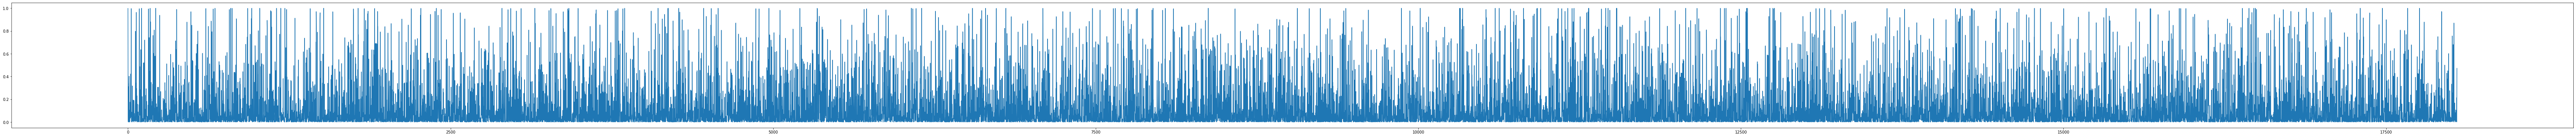

In [263]:
y_sub = sum(y_preds) / len(y_preds)
fig = plt.figure(figsize=(120.0, 6.0))
plt.plot(y_sub)
y_sub = (y_sub > percentage).astype(int)


sub['B'] = y_sub
sub.to_csv('submission_lightgbm_kfold.csv', index=False, header=False)

sum(sub["B"]),len(sub["B"])

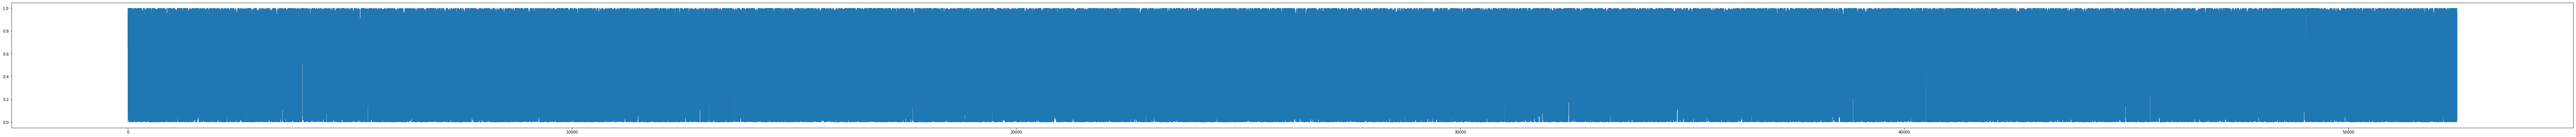

In [264]:
x = range(len(train))
y = oof_train
fig = plt.figure(figsize=(120.0, 6.0))
plt.plot(x, y)

#plt.xlim([0,10000])
plt.show()

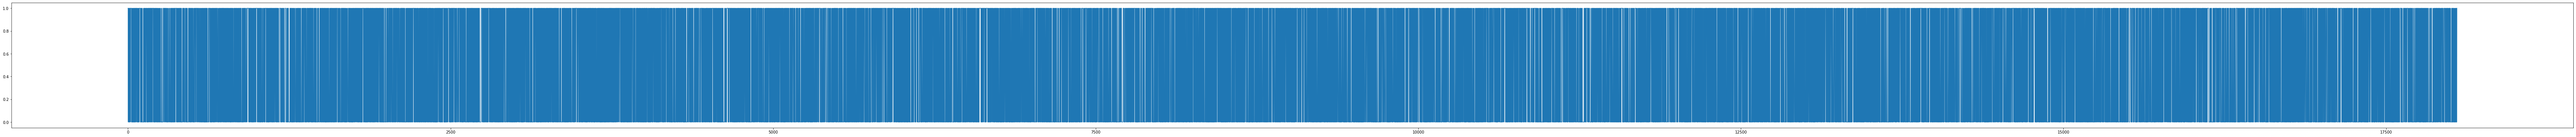

In [265]:
fig = plt.figure(figsize=(120.0, 6.0))
plt.plot(y_sub)


In [266]:
sub

,A,B
0,0,1
1,1,1
2,2,0
3,3,0
4,4,1
...,...,...
18045,18045,0
18046,18046,0
18047,18047,1
18048,18048,0


-----ここまでcross validation-------

In [269]:
files.download('submission_lightgbm_kfold.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>